# 1. Importamos librerías necesarias

In [1]:
import pandas as pd
import requests
import spacy
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import seaborn as sns

# 2. Conseguimos listado de ratings para evaluar la emotividad

Usamos la api haciendola consultas sobre los endpoints `/ratingsbyuser` y `/ratingsbyproduct`.

Directamente los importamos como DataFrames

In [2]:
usuario  = {"user"   : "RichBo"}
ratingslist = pd.DataFrame(requests.get("http://127.0.0.1:5000/ratingsbyuser",data=usuario).json())
ratingslist

,date,rating,rating_text,rating_title,recommended,username
0,"Fri, 12 Aug 2016 00:00:00 GMT",4,Alexa is very good a quickly satisfying your m...,Alexa is very good at quickly finding your music,True,RichBo


In [3]:
producto  = {"product"   : "Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets)"}
ratingslist = pd.DataFrame(requests.get("http://127.0.0.1:5000/ratingsbyproduct",data=producto).json())
ratingslist

,Product_name,rating,rating_text,rating_title,recommended
0,Amazon Kindle Fire 5ft USB to Micro-USB Cable ...,4,Alexa is very good a quickly satisfying your m...,Alexa is very good at quickly finding your music,True
1,Amazon Kindle Fire 5ft USB to Micro-USB Cable ...,5,Really enjoy our day to day interactions with ...,So fun and useful,True
2,Amazon Kindle Fire 5ft USB to Micro-USB Cable ...,3,Good speaker but limited if you don´t have a b...,Good speaker,True
3,Amazon Kindle Fire 5ft USB to Micro-USB Cable ...,5,Easy to use and very fun!! Use it for my PC sp...,Very Cool,True


Alternativamente podemos cargar el archivo CSV con todos los ratings y elegir unos ratings al azar.

In [4]:
ratingslist = pd.read_csv("../data/amazon_reviews_clean.csv")
ratingslist = ratingslist.sample(1000)
ratingslist.head()

,Product_name,rating,rating_text,rating_title,recommended,username,date,year,month,day
5304,Fire Tablet 7 Display Wi-Fi 8 GB - Includes Sp...,5.0,Was a christmas gift for my daughter she loves...,Christmas gift,True,Amylynn,2017-01-23,2017,1,23
15500,Fire Kids Edition Tablet 7 Display Wi-Fi 16 GB...,4.0,Got this for my 3 year old son. He plays with ...,Good beginner tablet,True,Darkbrotha,2017-03-14,2017,3,14
18170,Amazon Kindle Paperwhite - eBook reader - 4 GB...,5.0,Received this as a gift and is very useful. Ba...,Good one to have,True,Baskar,2016-05-20,2016,5,20
13894,Fire Tablet 7 Display Wi-Fi 8 GB - Includes Sp...,5.0,I own the Kindle Fire HD 6 and love it...this ...,Affordable e-reader,True,Tarheelval,2015-11-30,2015,11,30
475,All-New Fire HD 8 Tablet 8 HD Display Wi-Fi 16...,4.0,I will be ordering Amazon fire for my two gran...,Great for beginners,True,Mila,2016-11-25,2016,11,25


# 3 Definimos una funcion para tokenizar textos (core de SpaCy)

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
def tokenizer(texto) :
    tokens = nlp(texto)
    texto_tokenizado = []
    for token in tokens:
        if not token.is_stop:
            lemma = token.lemma_.lower().strip()
            if re.search('^[a-zA-Z]+$',lemma):
                texto_tokenizado.append(lemma)
    texto_tokenizado = " ".join(texto_tokenizado)
    return texto_tokenizado
    

# 4 Definimos una función para evaluar sentimientos (NLTK)

In [7]:
sia = SentimentIntensityAnalyzer()

In [8]:
def sentiment(texto):
    sia = SentimentIntensityAnalyzer()
    polaridad = sia.polarity_scores(texto)
    pol = polaridad["compound"]
    return pol

# 5. Tokenizamos y evaluamos emotivamente los textos del DataFrame

In [9]:
ratingslist["rating_text_tokenized"]    = ratingslist["rating_text"].apply(tokenizer)
ratingslist["sentiment_title"]          = ratingslist["rating_title"].apply(sentiment)
ratingslist["sentiment_text"]           = ratingslist["rating_text"].apply(sentiment)
ratingslist["sentiment_text_tokenized"] = ratingslist["rating_text_tokenized"].apply(sentiment)

ratingslist.head()


,Product_name,rating,rating_text,rating_title,recommended,username,date,year,month,day,rating_text_tokenized,sentiment_title,sentiment_text,sentiment_text_tokenized
5304,Fire Tablet 7 Display Wi-Fi 8 GB - Includes Sp...,5.0,Was a christmas gift for my daughter she loves...,Christmas gift,True,Amylynn,2017-01-23,2017,1,23,christmas gift daughter love,0.4404,0.7650,0.7964
15500,Fire Kids Edition Tablet 7 Display Wi-Fi 16 GB...,4.0,Got this for my 3 year old son. He plays with ...,Good beginner tablet,True,Darkbrotha,2017-03-14,2017,3,14,get year old son play good introduce education...,0.4404,0.6542,0.6486
18170,Amazon Kindle Paperwhite - eBook reader - 4 GB...,5.0,Received this as a gift and is very useful. Ba...,Good one to have,True,Baskar,2016-05-20,2016,5,20,receive gift useful battery power stay atleast...,0.4404,0.7384,0.6808
13894,Fire Tablet 7 Display Wi-Fi 8 GB - Includes Sp...,5.0,I own the Kindle Fire HD 6 and love it...this ...,Affordable e-reader,True,Tarheelval,2015-11-30,2015,11,30,kindle fire hd love christmas gift friend hope...,0.0000,0.9633,0.9633
475,All-New Fire HD 8 Tablet 8 HD Display Wi-Fi 16...,4.0,I will be ordering Amazon fire for my two gran...,Great for beginners,True,Mila,2016-11-25,2016,11,25,order amazon fire granddaughter love,0.6249,0.5423,0.5423


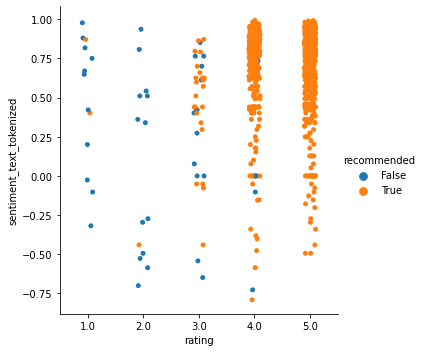

In [10]:
sns.catplot(x="rating", y="sentiment_text_tokenized", hue="recommended",data=ratingslist);

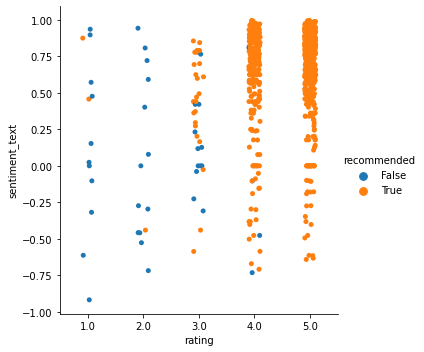

In [11]:
sns.catplot(x="rating", y="sentiment_text", hue="recommended",data=ratingslist);

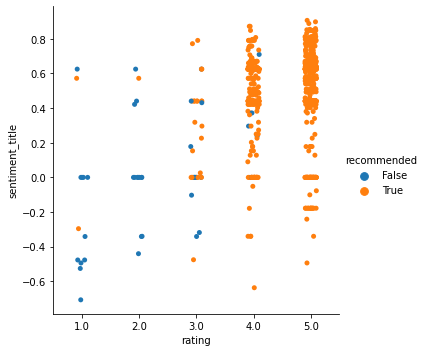

In [12]:
sns.catplot(x="rating", y="sentiment_title", hue="recommended",data=ratingslist);